In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



## Distribution of Monte Carlo estimates

Consider a single value, say $E$, estimated by Monte Carlo (we would like to know $E$!). Call $E$ the true value, and $e_i$ the estimate from a single Monte Carlo sample. Assume that $e_i$ are i.i.d., and have expectation value $E$. We estimate $E$ from $M$ samples as the sample mean:
$$
\bar{E}_M = \frac{1}{M} \sum_i e_i 
$$

The central limit theorem tells us that the distribution of $\bar{E}_M$ is normally distributed:
$$
\bar{E}_M \sim \mathcal{N}(E, \frac{\sigma}{\sqrt{M}}),
$$
where $\sigma$ is the standard deviation of $e_i$.

This has two important implications: 
1) You can simulate Monte Carlo by just adding Gaussian noise to a noiseless signal.
2) We know the function $\rho(\bar{E}_M| E)$, that is, given a value of $E$, we know the distribution of $\bar{E}$.

Here's an example of simulating Monte Carlo data.

We will use (1) throughout this as a way to check our procedures. The basic logic is that we start with the 'true' signal, add noise to generate data, and see whether the true signal lies within our uncertainty estimates.

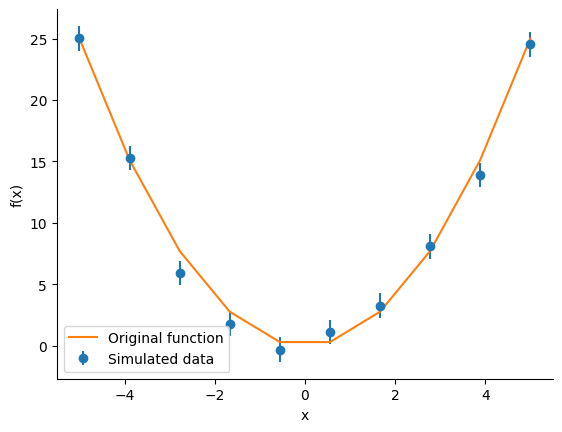

In [3]:
x = np.linspace(-5,5,10)
f = x**2
sigma = 1
y = f + np.random.normal(0,sigma,len(x))
plt.errorbar(x,y,yerr=np.ones_like(x)*sigma, marker='o', linestyle='none', label='Simulated data')
plt.plot(x,f, label='Original function')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
sns.despine()

## Inference

The central limit theorem only gives us $\rho(\bar{E}_M| E)$, which is not quite what we want. We *want* the other way around: 
$\rho(E|\{e_i\})$; our belief about the value of $E$ given the data we've collected. These two are related by Bayes' theorem: 
$$
\rho(E|\{e_i\}) = \frac{\rho(\{e_i\} | E) \rho(E)}{\rho(\{e_i\})} = \frac{\rho(\bar{E}_M | E) \rho(E)}{\rho(\{e_i\})}
$$

We can usually ignore the quantity $\rho(\{e_i\})$, which is the probability that we would have obtained the data.

However, the prior probability $\rho(E)$, is very important. It represents our belief about $E$ before we collect any data. This could come from any source, be that theory or otherwise. You had better be sure it's correct, because it does affect the results. 



True value:  0.1 Monte Carlo estimate:  0.012358176146833183


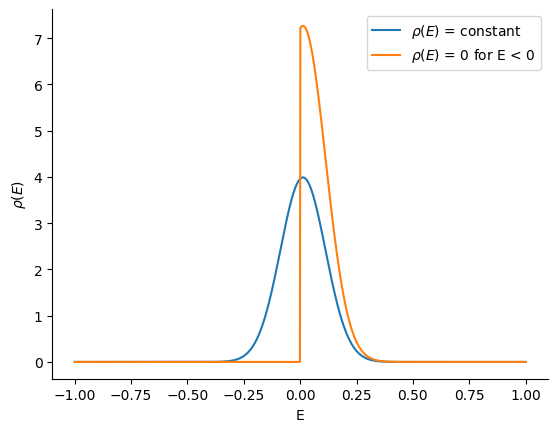

In [5]:
sigma=0.1
mc_estimate = 0.1 + np.random.normal(0,sigma)
print("True value: ", 0.1, "Monte Carlo estimate: ", mc_estimate)
x_estimate = np.linspace(-1,1,1000)
def rho_estimate(x):
    return np.exp(-(mc_estimate-x)**2/(2*sigma**2))
def rho_estimate_greater_0(x):
    if x > 0:
        return np.exp(-(mc_estimate-x)**2/(2*sigma**2))
    return 0

def rho_estimate_greater_0_vec(x):
    y=np.exp(-(mc_estimate-x)**2/(2*sigma**2))
    y[x<0]=0
    return y


import scipy.integrate as integrate
N_rho = integrate.quad(rho_estimate, -10, 10)
N_g0 = integrate.quad(rho_estimate_greater_0, -10, 10)

plt.plot(x_estimate, rho_estimate(x_estimate)/N_rho[0], label=r'$\rho(E)$ = constant')
plt.plot(x_estimate, rho_estimate_greater_0_vec(x_estimate)/N_g0[0], label=r'$\rho(E)$ = 0 for E < 0')
plt.legend()
plt.xlabel("E")
plt.ylabel(r"$\rho(E)$")
sns.despine()

## Propagating uncertainty 

Now let's suppose that we want to find out the distribution of some function of $E$, let's say $E^3$. The easiest thing to do is to take the integral
$$
\rho(E^3) = \int \delta (E'^3 - E^3) \rho(E'|\{e_i\}) dE'
$$

In some cases you can do this integral explicitly, but in general we do this by Monte Carlo sampling. 

All we need to do to estimate uncertainty is to, in some way, generate values of $E$ which are distributed according to $\rho(E|\{e_i\})$.

(aside: one can view bootstrap, leave-one-out, and cross-validation methods as ways of generating samples from $\rho$ without explicitly constructing it.)

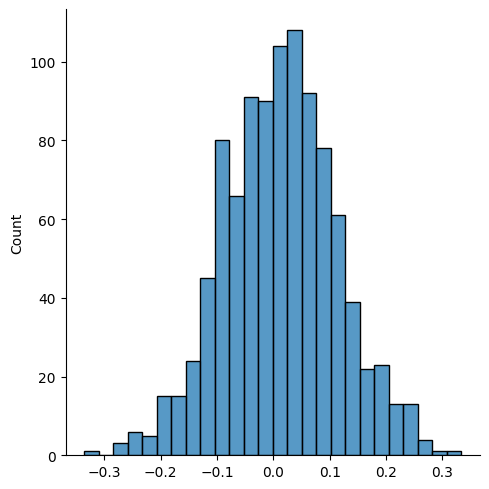

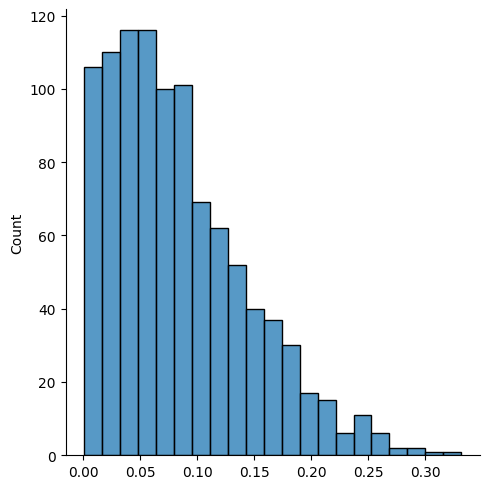

In [7]:
x_sample = np.linspace(-1,1,1000)
cdf_uniform_prior = np.cumsum(rho_estimate(x_sample)/N_rho[0])
cdf_g0_prior = np.cumsum(rho_estimate_greater_0_vec(x_sample)/N_g0[0])
def sample_from(x, cdf):
    wtot = cdf[-1]
    base = np.random.rand() * wtot
    i = np.searchsorted(cdf, base)
    return x[i]

x3s_uniform = [sample_from(x_sample, cdf_uniform_prior) for i in range(1000)]
x3s_g0 = [sample_from(x_sample, cdf_g0_prior) for i in range(1000)]

sns.displot(x3s_uniform, label=r'$\rho(E)$ = constant')
sns.displot(x3s_g0, label=r'$\rho(E)$ = 0 for E < 0')
